In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.linear_model import LinearRegression
import seaborn as sns
# sns.set_theme()
import math
import time

matplotlib.use("pgf")
plt.rcParams['pgf.texsystem'] = "pdflatex"
plt.rcParams['savefig.format'] = 'pgf'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['font.size'] = 20
plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = "Helvetica"
n_colors = 10
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", plt.cm.viridis(np.linspace(0,0.8,n_colors)))


rng = np.random.default_rng(11)

In [103]:
%load_ext autoreload
%autoreload 2
from utils import sim_MC, plot_results, plot_multi_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constant x (p=0) {-}

/var/folders/4h/h9s2_21x30jg2k3683jxrjv40000gn/T/ipykernel_10346/2489592124.py:131: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


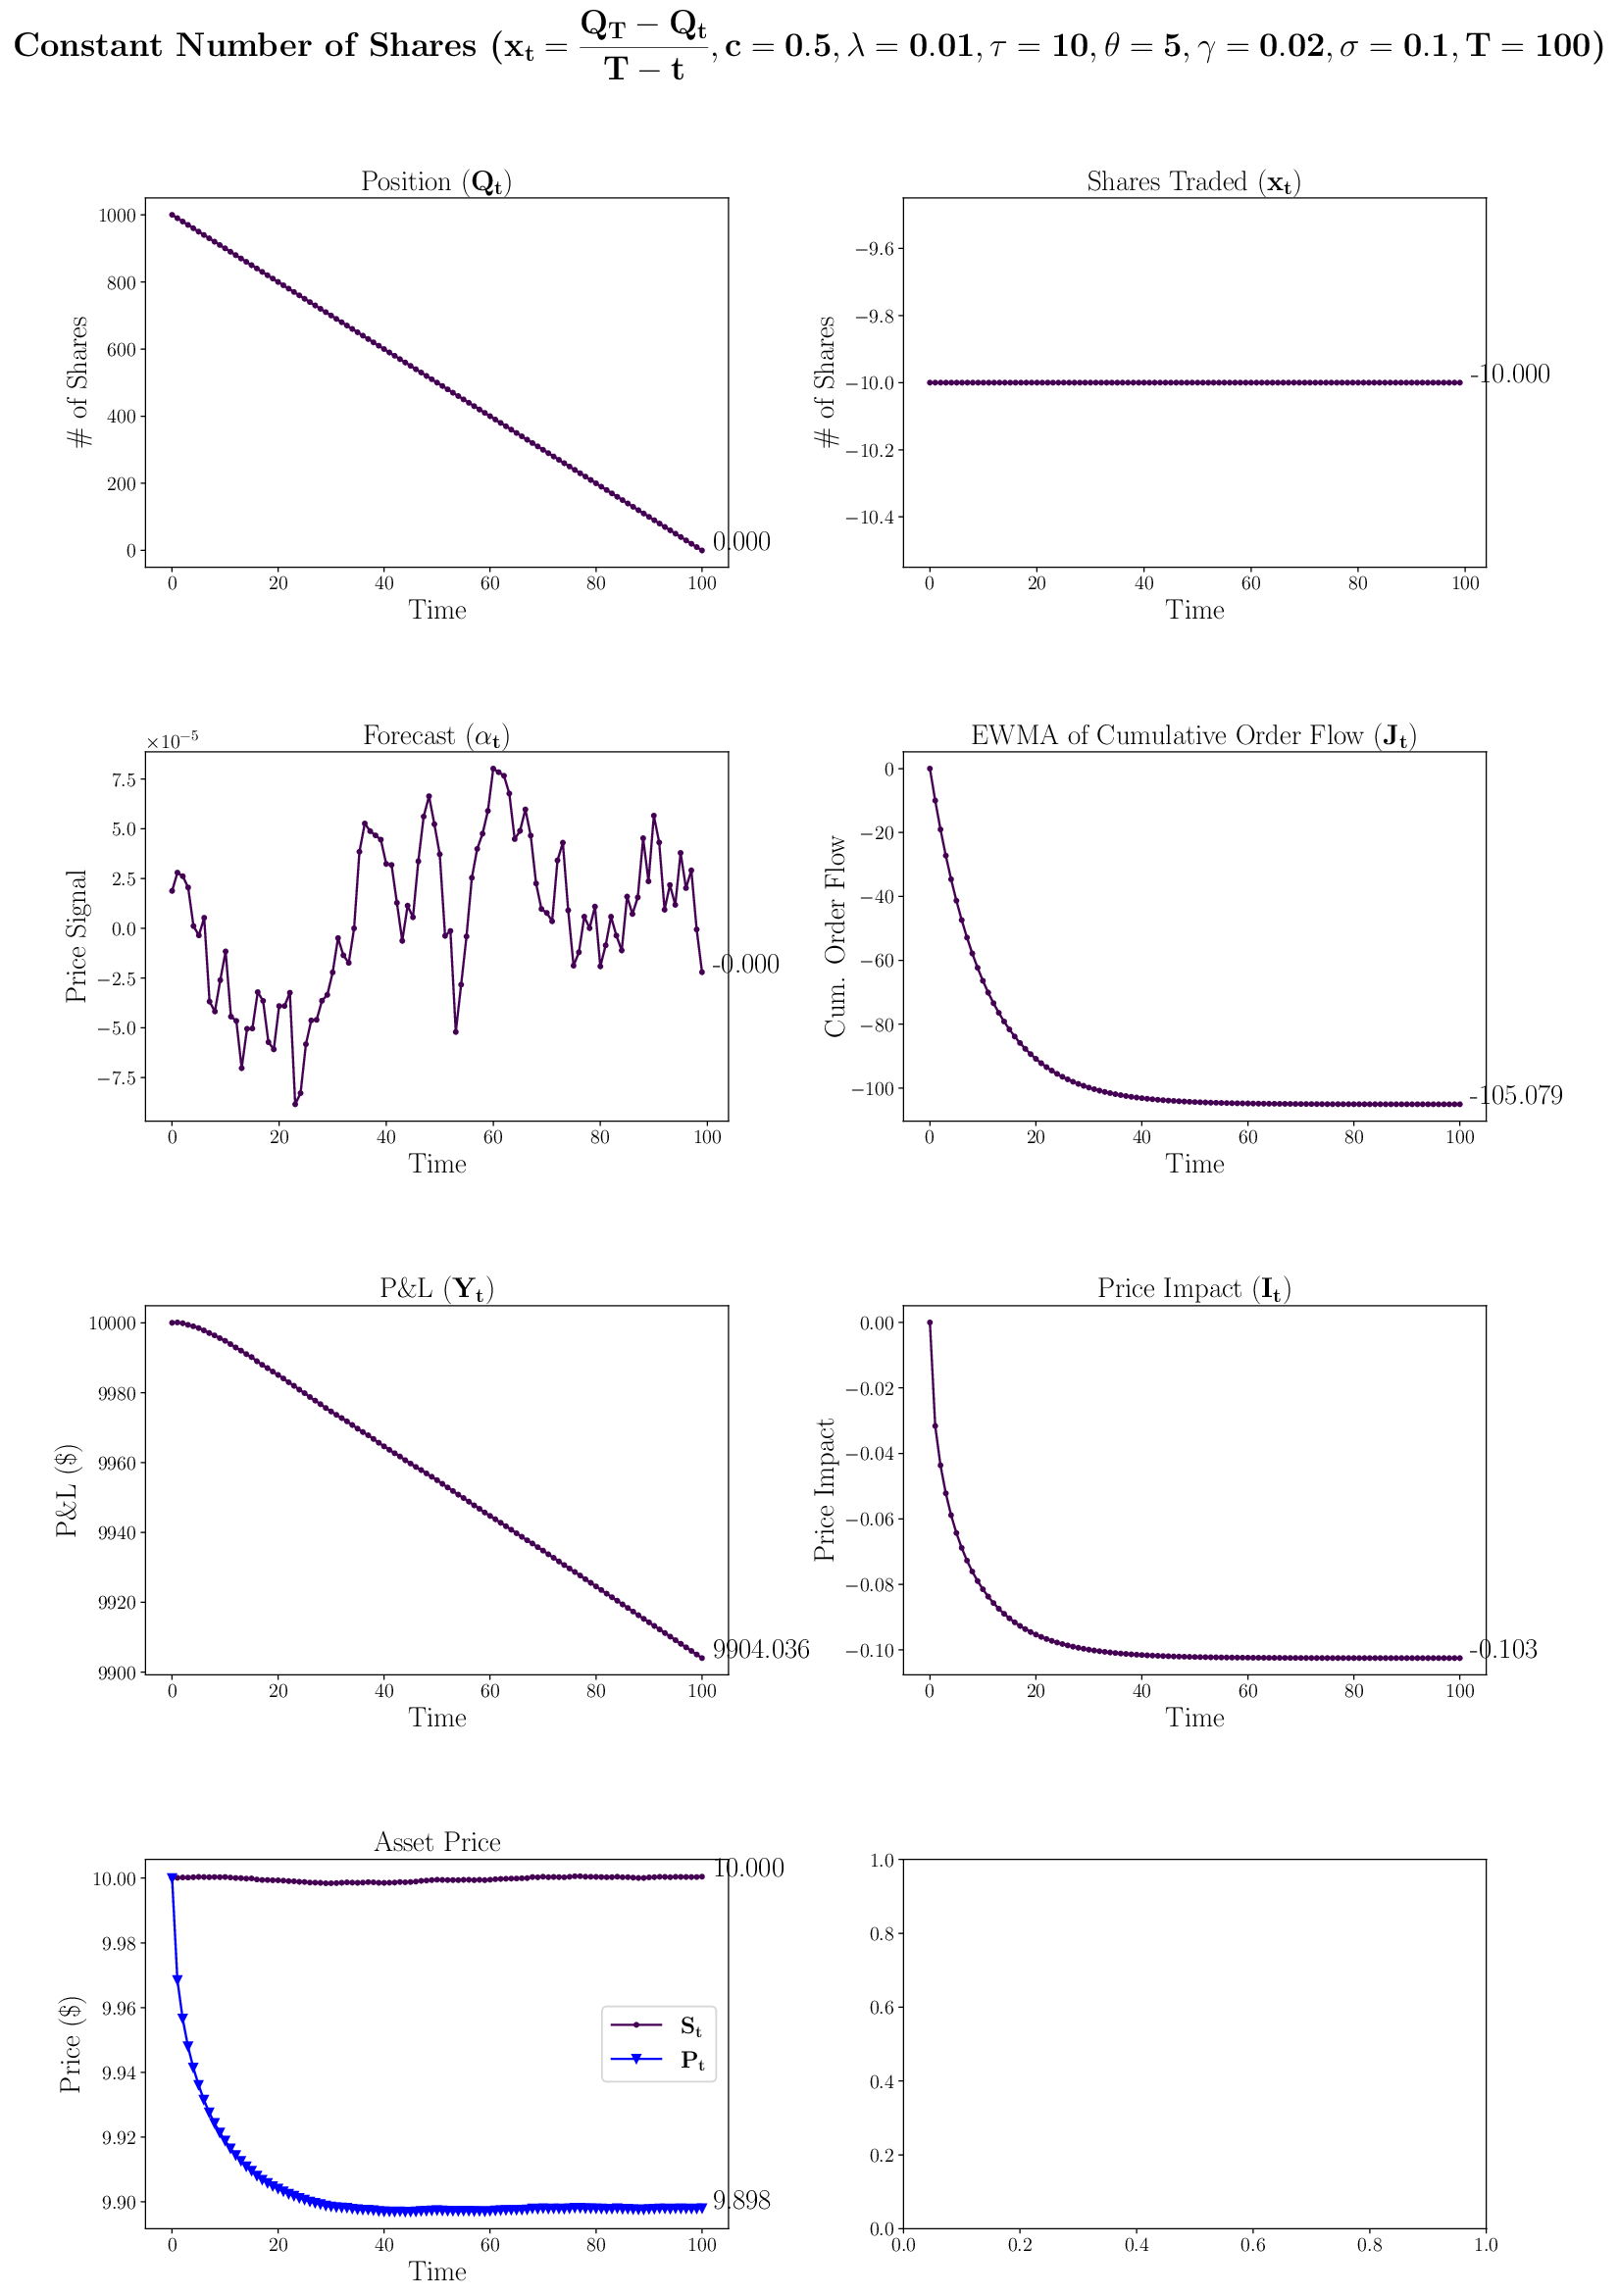

In [67]:
def const_x(rem_q, rem_t, **kwargs):
    '''
    Calculates number of shares to trade at each time step so that it's constant throughout the entire trading period.
    Takes in remaining quantity and remaining number of time steps
    '''
    assert 0 < rem_t, "rem_t<0"
    return rem_q/rem_t

params = {
    'init_q': 1000,
    'target_q': 0,
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'theta': 5,
    'gamma': 0.02,
    'T': 100,
    'sigma': 0.1,
    'n_MC': 500_000,
}

df = sim_MC(const_x, **params)
plot_results(fr"Constant Number of Shares ($\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}},c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\theta={params['theta']},\gamma={params['gamma']},\sigma={params['sigma']}, T={params['T']}}}$)", df, save_fig = False, fpath = "debug.png")

## Constant Number of Shares With Alpha {-}

/Users/edmundyoung/Desktop/Princeton/SeniorThesis/code/seniorthesis/utils.py:212: UserWarning: The figure layout has changed to tight
  
/Users/edmundyoung/Desktop/Princeton/SeniorThesis/code/seniorthesis/utils.py:226: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


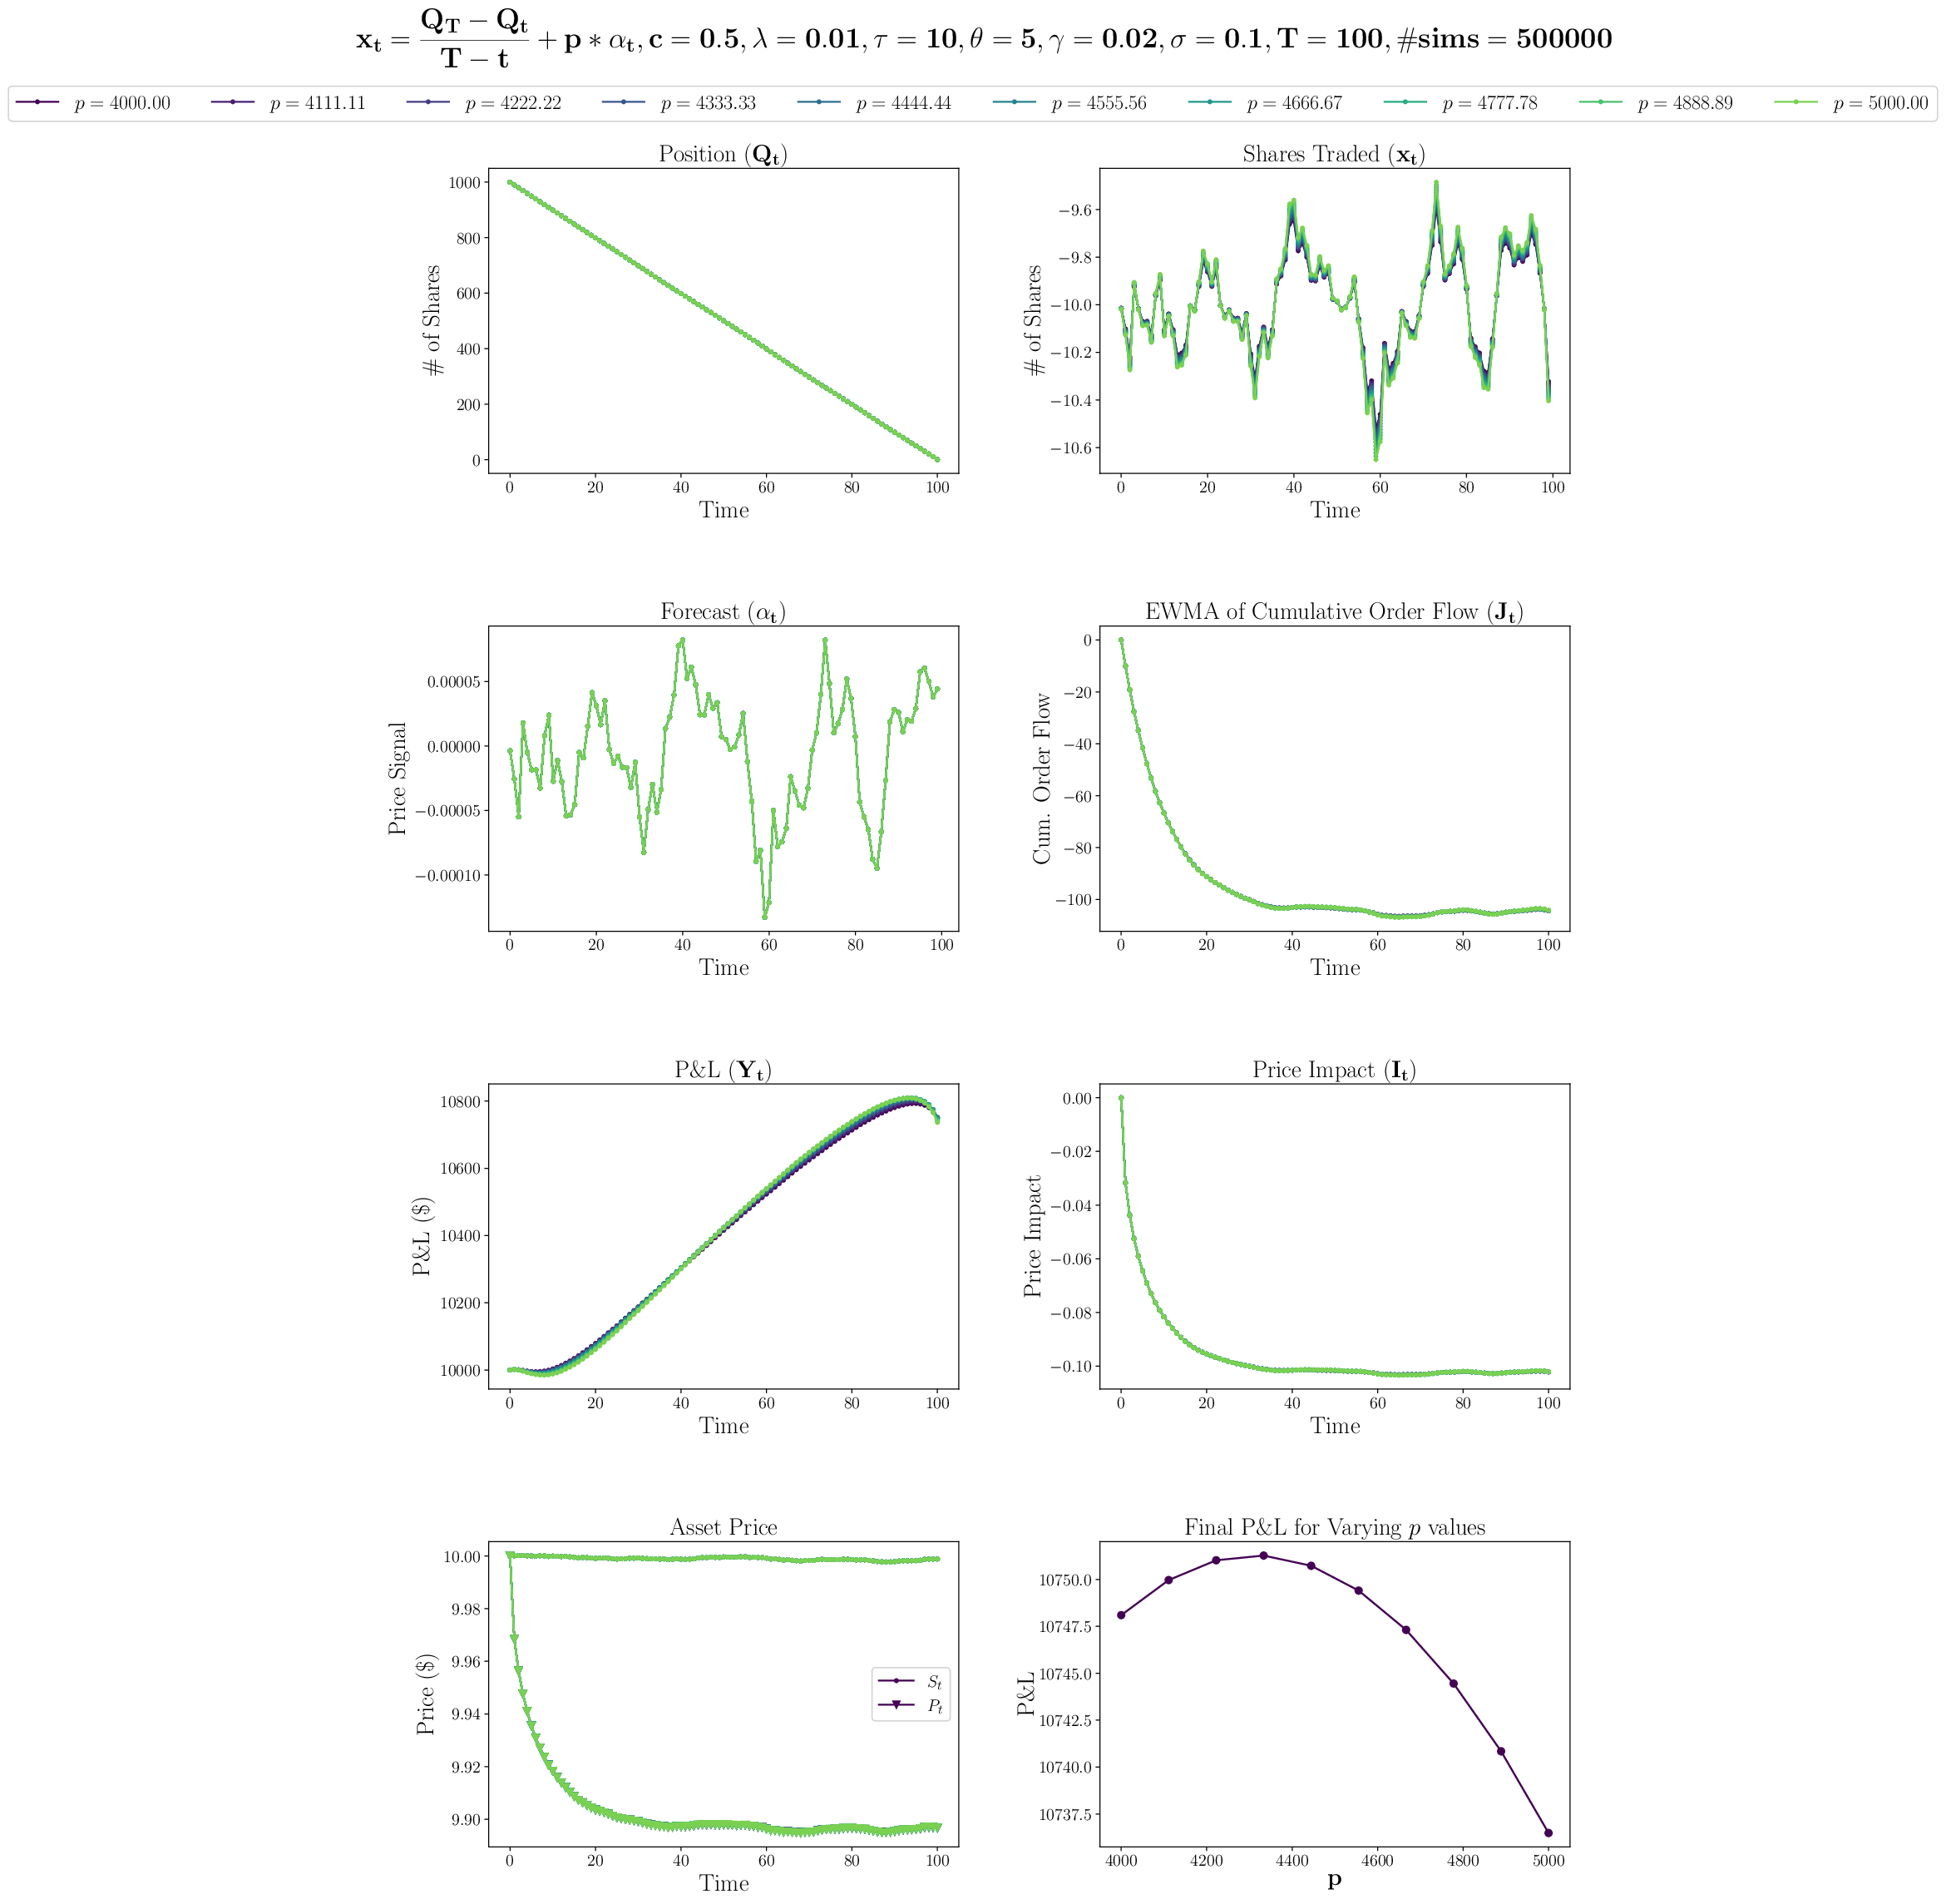

In [108]:
def const_num_alpha(p, rem_t, rem_q, alpha, **kwargs):
    '''
    Calculates the number of shares to trade for constant fraction plus alpha
    '''
    return rem_q/rem_t + p * alpha

d = {}
params = {
    'init_q': 1000,
    'target_q': 0,
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'theta': 5,
    'gamma': 0.02,
    'T': 100,
    'sigma': 0.1,
    'n_MC': 500_000,
}

for i in range(10):
    frac = 4000 + 1000/9 * i

    d[frac] = sim_MC(const_num_alpha, key_args = {'p': frac}, **params)

plot_multi_results(rf"$\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}}+p*\alpha_t,c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\theta={params['theta']},\gamma={params['gamma']},\sigma={params['sigma']},T={params['T']},\#sims={params['n_MC']}}}$", d, save_fig=False, fpath = None)

/Users/edmundyoung/Desktop/Princeton/SeniorThesis/code/seniorthesis/utils.py:213: UserWarning: The figure layout has changed to tight
  
/Users/edmundyoung/Desktop/Princeton/SeniorThesis/code/seniorthesis/utils.py:227: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


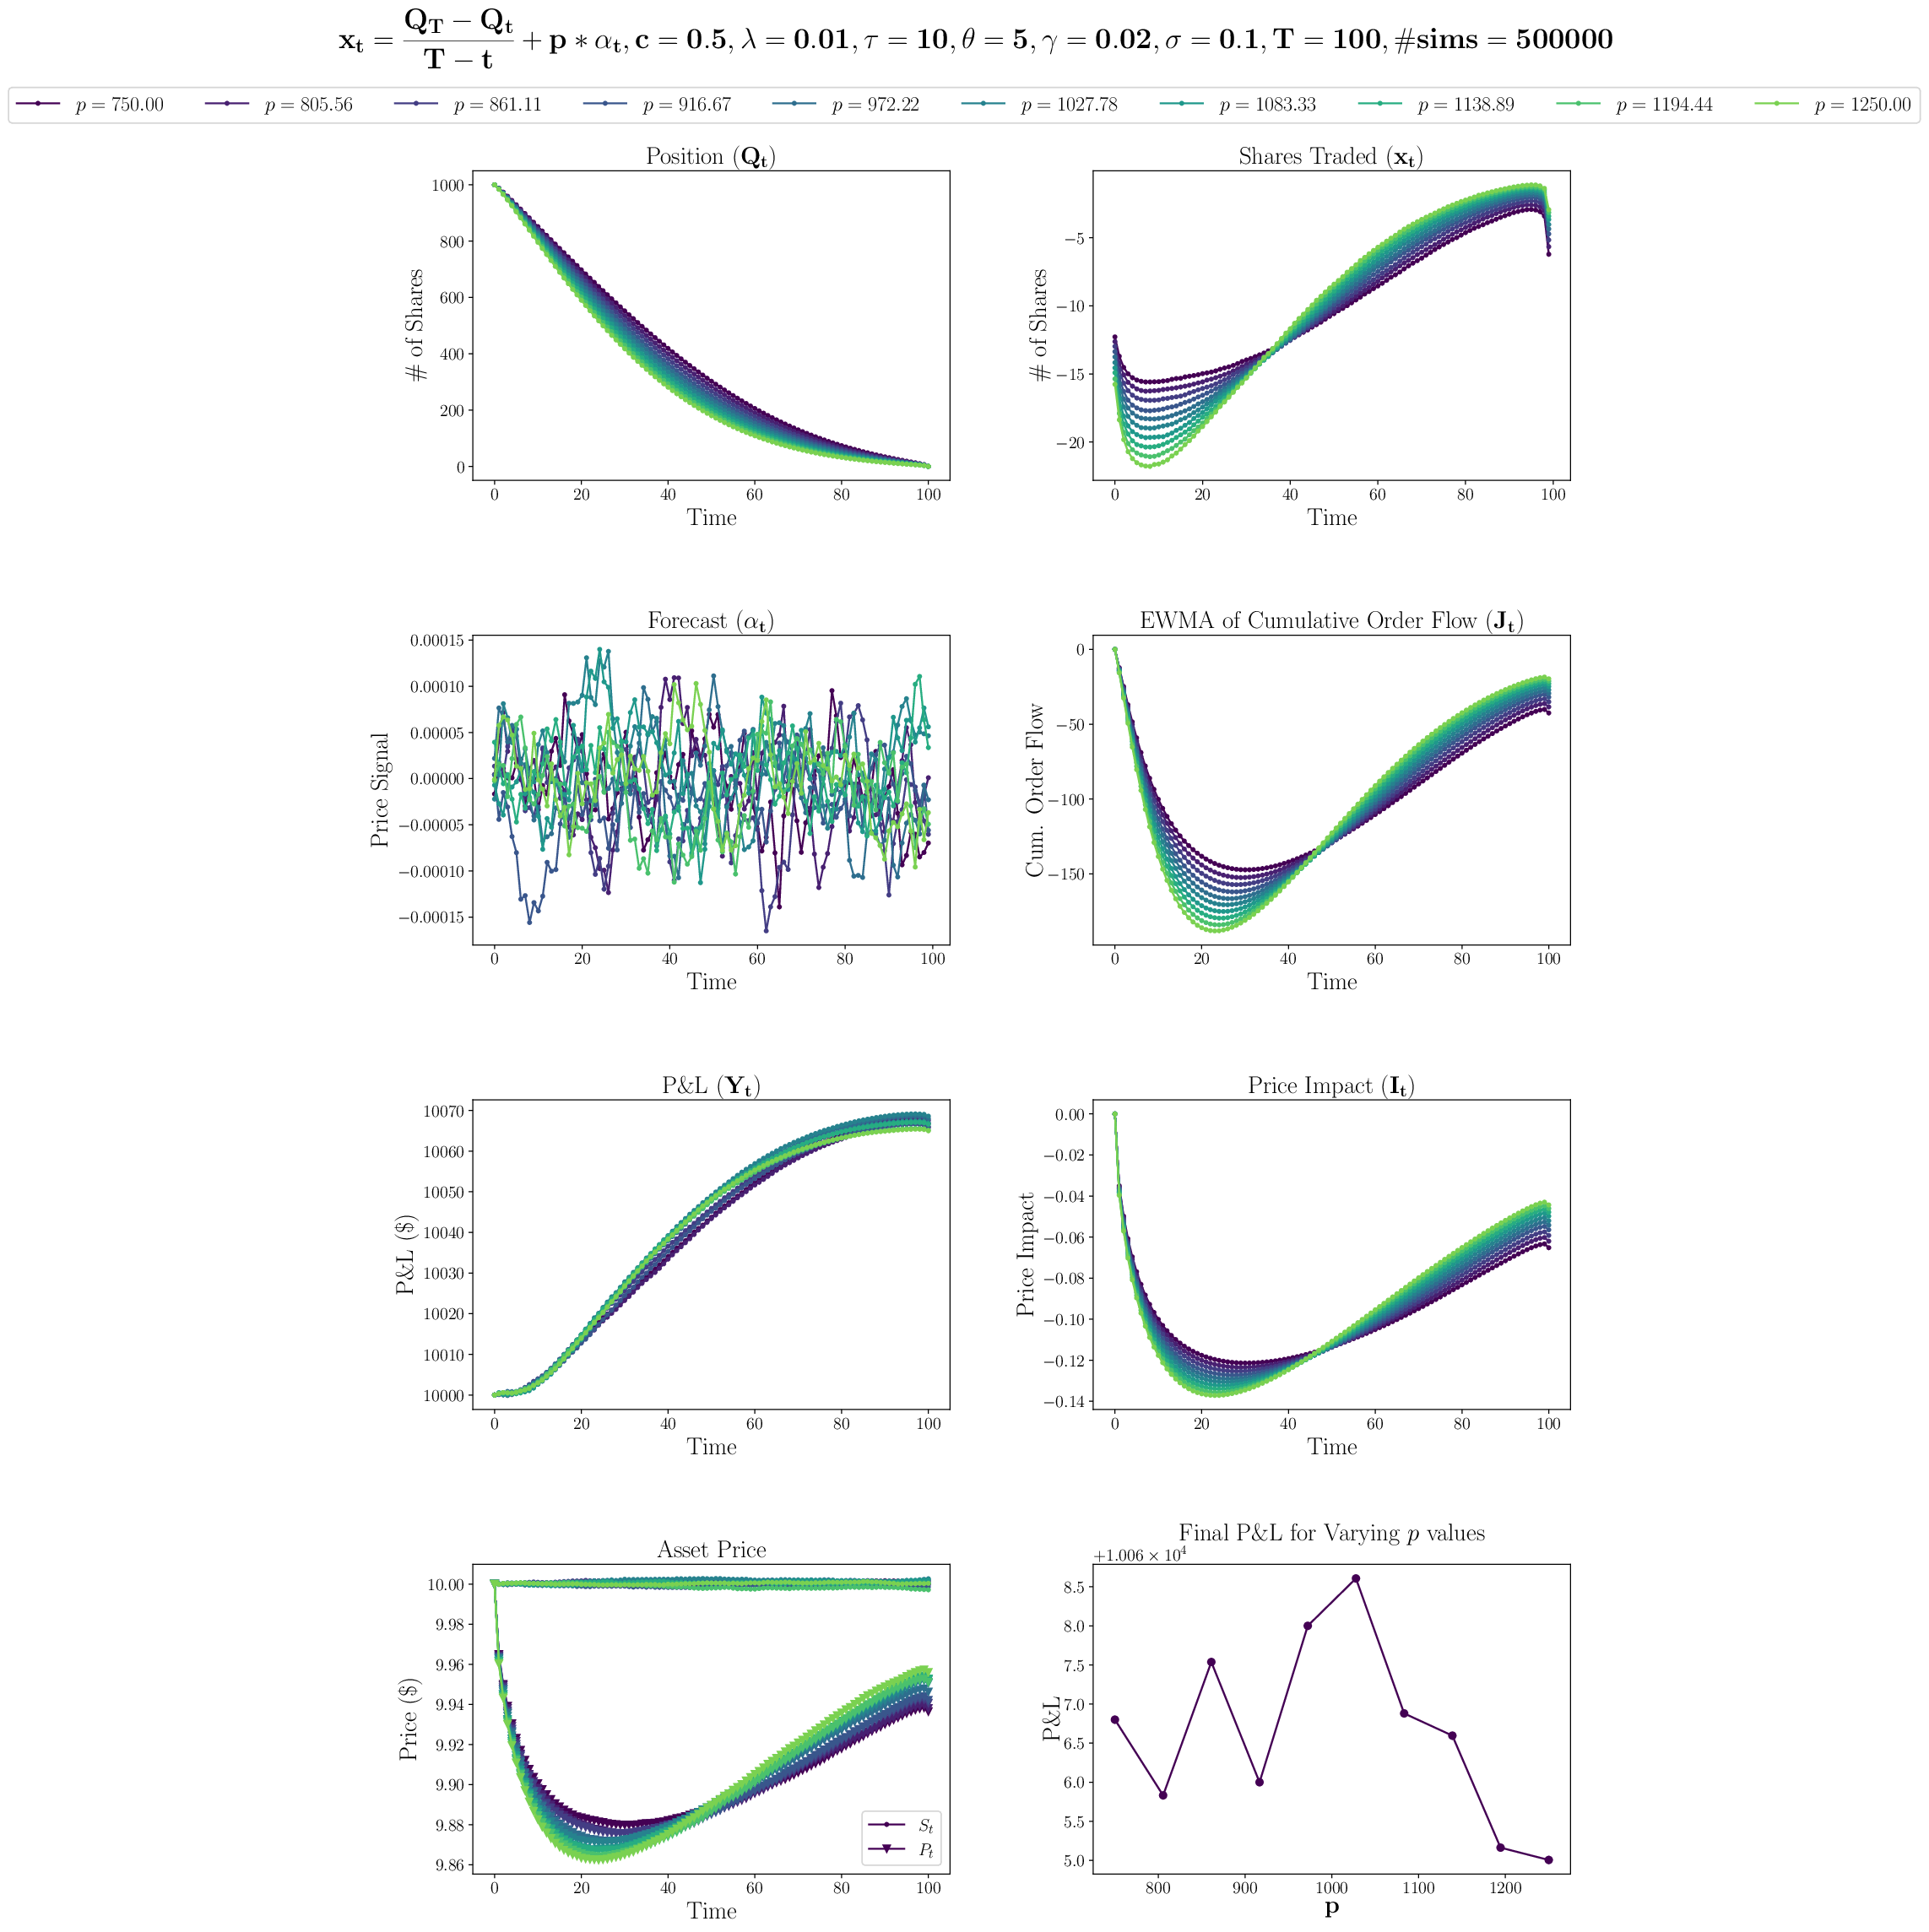

In [134]:
def const_num_alpha_only_buy(p, rem_t, rem_q, alpha, **kwargs):
    '''
    Calculates the number of shares to trade for constant fraction plus alpha (can only buy)
    '''

    x = np.maximum(rem_q/rem_t + p * alpha, 0)
    return np.minimum(x, rem_q)

def const_num_alpha_only_sell(p, rem_t, rem_q, alpha, **kwargs):
    '''
    Calculates the number of shares to trade for constant fraction plus alpha (can only sell)
    '''
    x = np.minimum(rem_q/rem_t + p * alpha, 0)
    return np.maximum(x, rem_q)

d = {}
params = {
    'init_q': 1000,
    'target_q': 0,
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'theta': 5,
    'gamma': 0.02,
    'T': 100,
    'sigma': 0.1,
    'n_MC': 500_000,
}

for i in range(10):
    frac = 750 + 500/9 * i
    params['seed'] = rng.integers(10000)
    d[frac] = sim_MC(const_num_alpha_only_sell, key_args = {'p': frac}, **params)

plot_multi_results(rf"$\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}}+p*\alpha_t,c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\theta={params['theta']},\gamma={params['gamma']},\sigma={params['sigma']},T={params['T']},\#sims={params['n_MC']}}}$", d, save_fig=True, fpath = "optimal_p.png")

/Users/edmundyoung/Desktop/Princeton/SeniorThesis/code/seniorthesis/utils.py:212: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=3.0)
/Users/edmundyoung/Desktop/Princeton/SeniorThesis/code/seniorthesis/utils.py:226: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


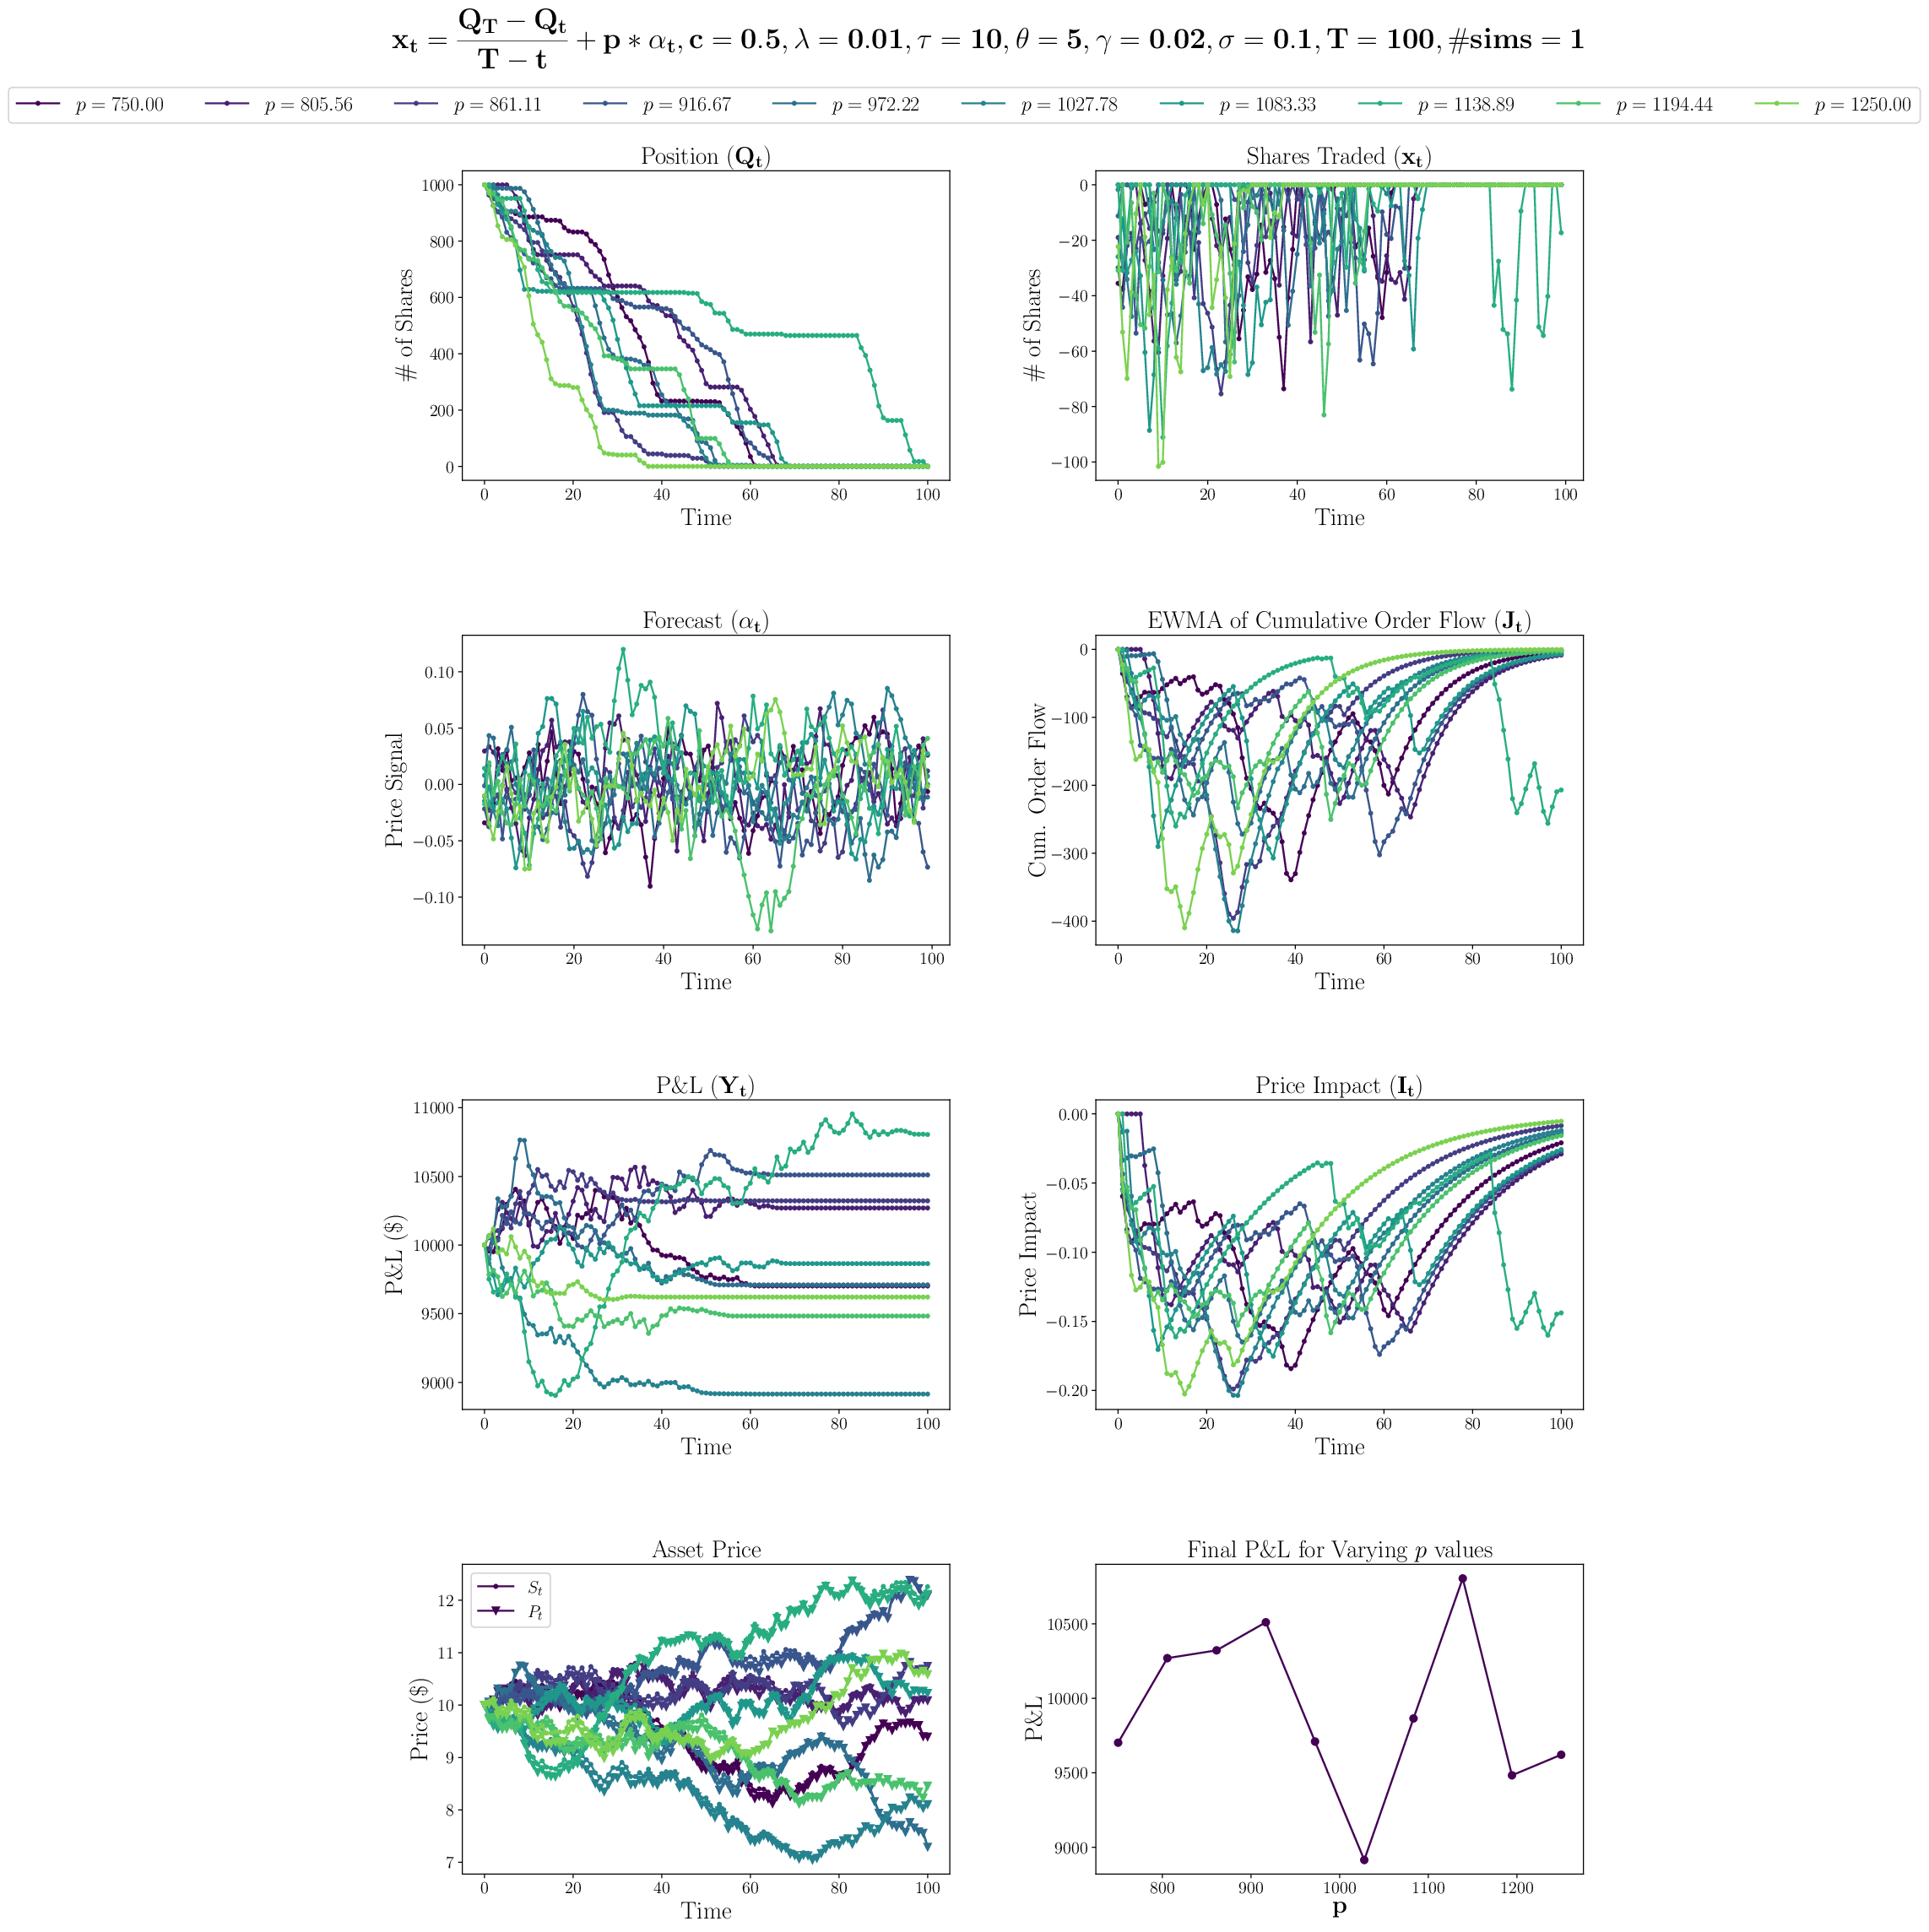

In [132]:
d = {}
params = {
    'init_q': 1000,
    'target_q': 0,
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'theta': 5,
    'gamma': 0.02,
    'T': 100,
    'sigma': 0.1,
    'n_MC': 1,
}

for i in range(10):
    frac = 750 + 500/9 * i
    params['seed'] = rng.integers(10000)
    d[frac] = sim_MC(const_num_alpha_only_sell, key_args = {'p': frac}, **params)

plot_multi_results(rf"$\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}}+p*\alpha_t,c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\theta={params['theta']},\gamma={params['gamma']},\sigma={params['sigma']},T={params['T']},\#sims={params['n_MC']}}}$", d, save_fig=True, fpath = "one_traj.png")

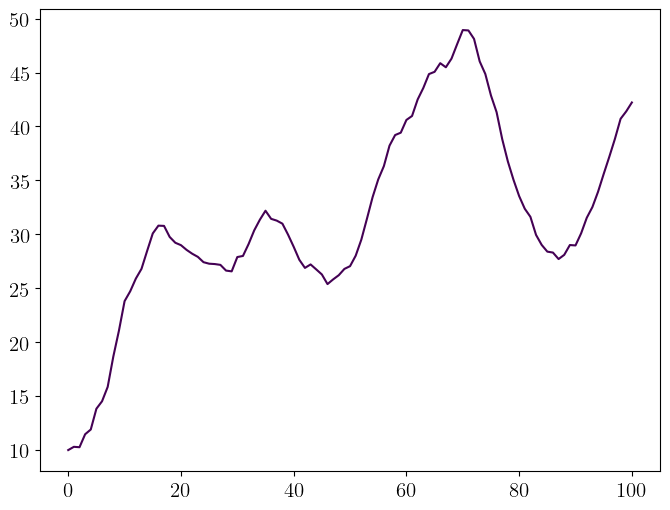

In [126]:
rw = np.zeros(101)
rw[0] = 10
a = 0
for i in range(100):
    a = np.exp(-1/10) * a + 0.5*rng.standard_normal()
    rw[i+1] = rw[i] + 0.3 * rng.standard_normal() + a
plt.plot(rw)

KeyboardInterrupt: 

In [6]:
np.linspace(0, 11, 3)


array([ 0. ,  5.5, 11. ])